
# Stance Detection on Tweets using NLP Methods

Note: This tutorial consists of two separate python notebooks. This notebook is the first one. The second notebook can be found [here](https://colab.research.google.com/drive/1IFr6Iz1YH9XBWUKcWZyTU-1QtxgYqrmX?usp=sharing). I recommend that you go through the first notebook before the second one as the second notebook builds on top of the first one.

1. First notebook (this one): Fine-tuning BERT models: include standard BERT and domain-specific BERT
- link: https://colab.research.google.com/drive/1nxziaKStwRnSyOLI6pLNBaAnB_aB6IsE?usp=sharing

2. Second notebook: Promoting large language models (LLMs): include ChatGPT, FLAN-T5 and different prompt types (zero-shot, few-shot, chain-of-thought)
- link: https://colab.research.google.com/drive/1IFr6Iz1YH9XBWUKcWZyTU-1QtxgYqrmX?usp=sharing

## Getting Started: Overview, Prerequisites, and Setup

**Objective of the tutorial**: This tutorial will guide you through the process of stance detection on tweets using two main approaches: fine-tuning a BERT model and using large language models (LLMs).

**Prerequisites**: 

- If you want to run the tutorial without editting the codes but want to understand the content
  - Basic Python skills: functions, classes, pandas, etc.
  - Basic ML knowledge: train-validation-test split, F1 score, forward pass, backpropagation etc.

- Familiarity with NLP concepts is a plus, particularly with transformers. However, if you're not familiar with them, don't worry. I'll provide brief explanations in the tutorial, as well as links to fantastic in-depth resources throughout the text.

**Acknowledgements**

- While the application of BERT on stance detection is my own work, some part of this tutorials, e.g., transformer and BERT, are inspired by the following tutorials. Some of the figures are also modified from the images in these tutorials. I highly recommend you to check them out if you want to learn more about transformers and BERT.
  - http://jalammar.github.io/illustrated-transformer/
  - http://jalammar.github.io/illustrated-bert/
- This tutorial was created with the assistance of ChatGPT (GPT-4), a cutting-edge language model developed by OpenAI. The AI-aided writing process involved an iterative approach, where I provided the model with ideas for each section and GPT-4 transformed those ideas into well-structured paragraphs. Even the outline itself underwent a similar iterative process to refine and improve the tutorial structure. Following this, I fact-checked and revised the generated content, asking GPT-4 to make further revisions based on my evaluation, until I took over and finalized the content.

**Setup**

1. Before we begin with Google Colab, please ensure that you have selected the GPU runtime. To do this, go to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`. This will ensure that the note will run more efficiently and quickly.

2. Now, let's download the content of this tutorial and install the necessary libraries by running the following cell.

In [46]:
from os.path import join
ON_COLAB = False
if ON_COLAB:
  !git clone https://github.com/yunshiuan/prelim_stance_detection.git
  !python -m pip install pandas datasets openai accelerate transformers transformers[sentencepiece] torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html emoji -q
  %cd /content/prelim_stance_detection/scripts
else:
  # if you are not on colab, you have to set up the environment by yourself. You would also need a machine with GPU.
  %cd scripts

[Errno 2] No such file or directory: 'scripts'
/home/sean/prelim_stance_detection/scripts


In [47]:
# a helper function to load images in the notebook
from IPython.display import display
from PIL import Image as PILImage
from parameters_meta import ParametersMeta as par
PATH_IMAGES = join(par.PATH_ROOT, "images")


def display_resized_image_in_notebook(file_image, scale=1, use_default_path=True):
    """ Display an image in a notebook.
    """
    # - https://stackoverflow.com/questions/69654877/how-to-set-image-size-to-display-in-ipython-display
    if use_default_path:
        file_image = join(PATH_IMAGES, file_image)
    image = PILImage.open(file_image)
    display(image.resize((int(image.width * scale), int(image.height * scale))))


****

## What is Stance Detection and Why is it Important?

Stance detection is an essential task in natural language processing that aims to determine the attitude expressed by an author towards a specific target, such as an entity, topic, or claim. The output of stance detection is typically a categorical label, such as "in-favor," "against," or "neutral," indicating the stance of the author in relation to the target. This task is critical for studying human belief dynamics, e.g., how people influence each other's opinions and how beliefs change over time. To better understand the complexities involved in stance detection, let's consider an example related to the topic of "abortion legalization".

For example, consider the following tweet:

"**_A pregnancy, planned or unplanned, brings spouses, families & everyone closer to each other. #Life is beautiful! #USA_**"

In this case, the stance expressed towards the topic of abortion legalization might be inferred as against, but the clues indicating the author's attitude are implicit and subtle - notice that it does not explicitly mention abortion, making it challenging to determine the stance without careful examination and contextual understanding.

There are two key challenges in stance detection, especially when working with large datasets like Twitter data. First, as illustrated above, the underlying attitude expressed in the text is often subtle, which requires domain knowledge and context to correctly label the stance. Second, the corpus can be very large, with millions of tweets, making it impractical to manually annotate all of them.

To address these challenges, we will leverage advanced natural language processing (NLP) techniques including two paradigms, 1) fine-tuning BERT model, and 2) prompting large language models (LLMs). I will elaborte the details of these two approaches in the following sections.

Before discussing the two paradigms for addressing the challenges in stance detection, it's essential to understand the difference between <u>**sentiment analysis**</u> and <u>**stance detection**</u>, as these two tasks are often confused.

Sentiment analysis involves identifying the overall emotional tone expressed in a piece of text, usually categorized as positive, negative, or neutral. In contrast, stance detection aims to determine the specific attitude of an author towards a target. While sentiment analysis focuses on the general emotional valence of the text, stance detection requires a deeper understanding of the author's position concerning the target topic.

To illustrate that sentiment and stance are orthogonal concepts, consider the following four examples, each representing a combination of two stance types (against and in-favor) and two sentiments (positive and negative):

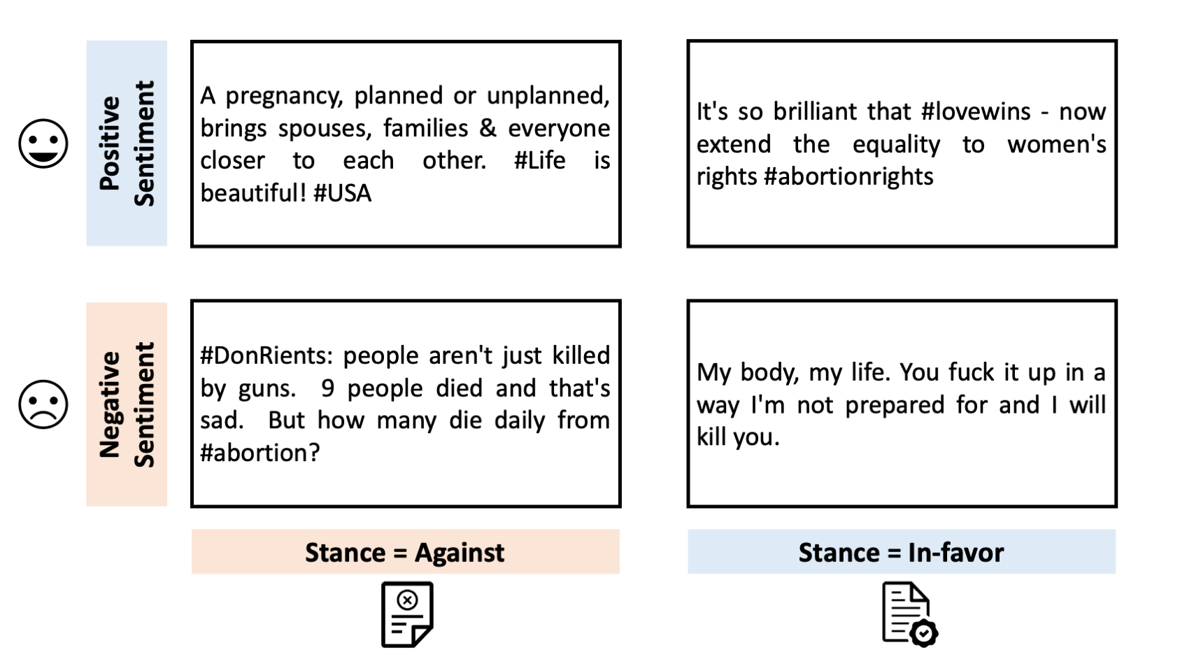

In [48]:
display_resized_image_in_notebook("stance_vs_sentiment.png",0.7)


In this tutorial, we will focus on stance detection in the context of the "Abortion" topic using the SemEval-2016 dataset. We chose the abortion topic because it is currently a hotly debated issue, and it is important to understand public opinion on this matter. We will analyze a dataset containing tweets about abortion, with each tweet labeled as either in-favor, against, or neutral with respect to the topic. My goal is to develop a model that can accurately identify the stance expressed in these tweets.

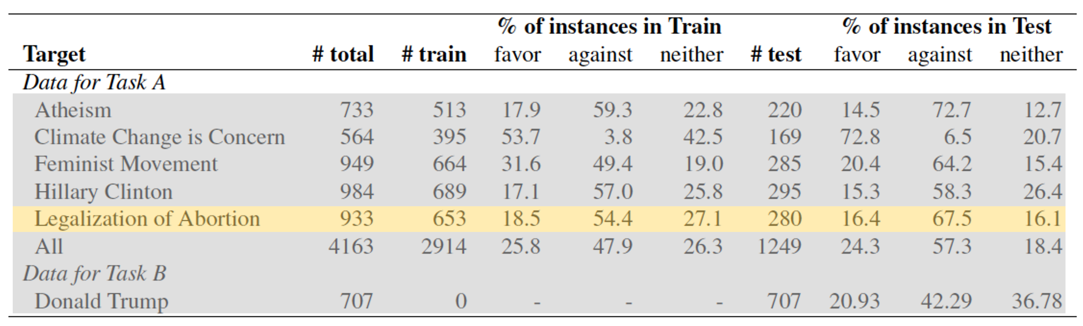

In [49]:
display_resized_image_in_notebook("dataset_semeval_abortion.png",scale = 0.25)

> Note: The SemEval-2016 dataset contains tweets related to six different topics: Abortion, Atheism, Climate Change, Feminist Movement, Hillary Clinton, and Legalization of Abortion. In this tutorial, we will focus on the Abortion topic only. However, you can easily extend the tutorial to other topics. For an interactive visualization of the SemEval-2016 dataset, please visit [here](https://www.saifmohammad.com/WebPages/StanceDataset.htm).

****

## Two Stance Detection Paradigms

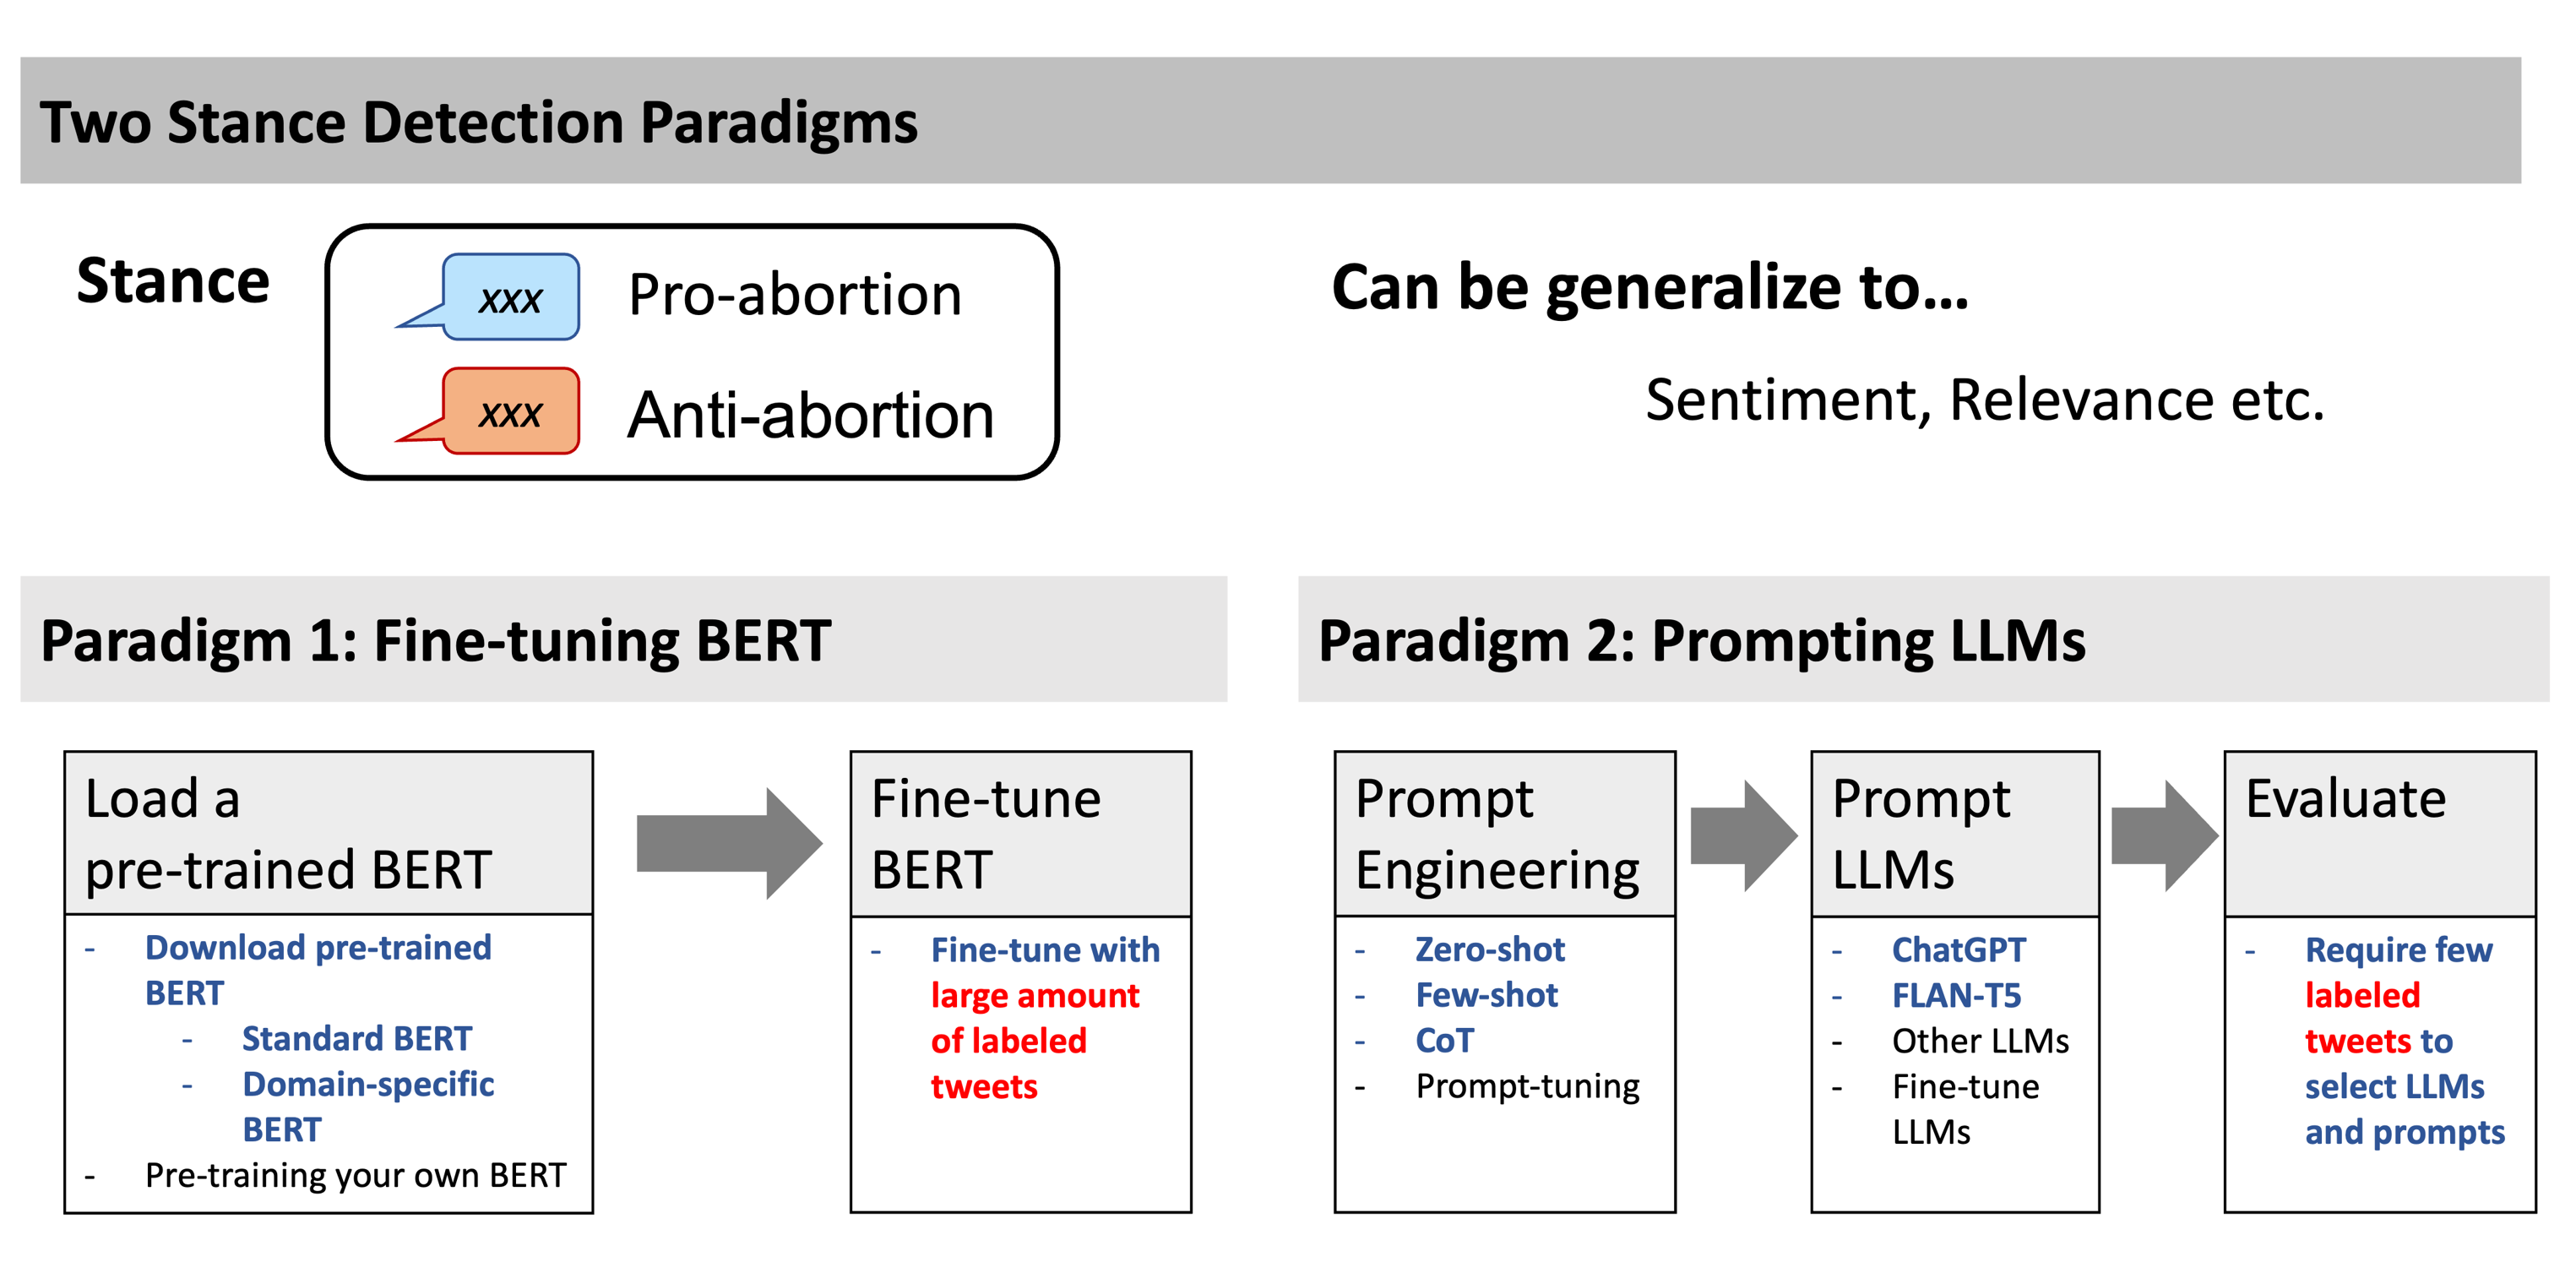

In [50]:
display_resized_image_in_notebook("stance_detection_two_paradigm.png", 0.7)

> The diagram above illustrates the two paradigms for stance detection: (1) Fine-tuning a BERT model and (2) Prompting Large Language Models (LLMs). The red text highlights the key practical difference between the two approaches, which is the need for large labeled data when fine-tuning a BERT model. The blue texts indicates the parts covered in these two tutorials. While the black parts are not covered in these tutorials, they are important to consider when applying these two paradigms in practice.

In this tutorial, we are exploring two different paradigms for stance detection: 1) fine-tuning a BERT model, and 2) prompting large language models (LLMs) like ChatGPT. 

Fine-tuning a BERT model involves training the model on a specific task using a labeled dataset, which adapts the model's pre-existing knowledge to the nuances of the task. This approach can yield strong performance but typically requires a substantial amount of labeled data for the target task.

On the other hand, prompting LLMs involves crafting carefully designed input prompts that guide the model to generate desired outputs based on its pre-trained knowledge. This method does not require additional training, thus significantly reducing the amount of labeled data needed. Note that some labeled data is still required to evaluate the performance.

In this first tutorial, we will focus on the first paradigm: fine-tuning a BERT model, including domain-specific BERT which may be more suitable for our task. In [the second tutorial](https://colab.research.google.com/drive/1IFr6Iz1YH9XBWUKcWZyTU-1QtxgYqrmX?usp=sharing), we will explore the second paradigm: prompting LLMs.

****


# Paradigm 1: using BERT for stance detection

In this section, I will briefly introduce BERT, a powerful NLP model that has been widely used in many NLP tasks. we will explain what BERT is, how it is trained, and how it can be used for stance detection. we will also show you how to fine-tune BERT for stance detection using python.

## What is BERT and how it works

BERT, which stands for _**B**idirectional **E**ncoder **R**epresentations from **T**ransformers_, is a groundbreaking natural language processing (NLP) model that has taken the world by storm. Created by researchers at Google in 2018, BERT is designed to learn useful representations for words from unlabeled text, which can then be tailored, or, "fine-tuned" for a wide range of NLP tasks, such as stance detection, sentiment analysis, question-answering, among many.


> Note: "Unlabeled text" means that the text does not have any labels, such as the sentiment, or stance, of a tweet. This is in contrast to supervised learning, where the training data is labeled. In supervised learning, the model learns to predict the labels of the text of the training data. When pre-training BERT on unlabeled data, it learns to predict the randomly masked out words in a sentence (explained in details below).

In a nutshell, BERT is a powerful NLP model that leverages 1) the transformer architecture and 2) the pre-training and fine-tuning approach. we will explain these two concepts in more details below.

> Note: In this tutorial, my primary focus is on applying NLP models for stance detection, and I won't be elabortating all the details of BERT. If you're interested in learning more about BERT, I highly recommend checking out the excellent interactive tutorial available at http://jalammar.github.io/illustrated-bert/. This tutorial provides a thorough and visually engaging explanation of BERT's inner workings. Some of the plots in my tutorial are borrowed from this resource. 


### Bidirectional Context: Understanding Context in Both Directions

Language is complex, and understanding it is no simple task. Traditional NLP models (e.g., RNN; no worries if you don't know what RNN is) have focused on reading text in one direction (e.g.,from left-to-right), making it difficult for them to grasp the full context when trying to understand a word. BERT, however, is designed to process text in both directions, allowing it to understand the meaning of words based on the words that come before and after them.

To explain how this is possible, we first need to understand what a transformer is, and specifically, the critical "self-attention mechanism" component that makes it possible for BERT to understand context in both directions.


****


### A Powerful Backbone Architecture: Transformers with Self-Attention Mechanism

BERT is built upon the <u>**transformer architecture**</u>, the critical backbone of many state-of-the-art NLP models (including both BERT and the LLMs described in the second tutorial), was introduced by Vaswani et al. in their 2017 paper, "Attention Is All You Need."

The key component of the architecture is the "<u>**self-attention mechanism**</u>", which helps the model identify important parts of the input text and understand the relationships between words.


Let's use the concrete example below to illustrate the self-attention mechanism.

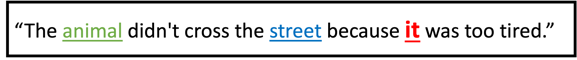

In [52]:
display_resized_image_in_notebook("example_sentence_self_attention.png",0.2)

In this example, what does "<u>**it**</u>" refer to? Does it refer to the <u>animal</u> or the <u>street</u>?

As humans, we understand that "<u>it</u>" refers to the "<u>animal</u>". However, for a machine, determining the correct reference is not a simple task, especially given that the word "<u>street</u>" is closer to "<u>it</u>" than "<u>animal</u>" in the sentence. A naive machine might assume that "<u>it</u>" refers to the "<u>street</u>" because the word "<u>street</u>" is closer to "<u>it</u>" than "<u>animal</u>".

We, as humans, know that "<u>it</u>" refers to the "<u>animal</u>" because we understand that animals can get tired while streets cannot. We also recognize that being too tired is a legitimate reason for not crossing the street. In summary, we can comprehend the meaning of the word "<u>it</u>" by taking into account other words in the sentence, or, in technical terms, the "context".

With the help of the self-attention mechanism, a transformer model takes into account of the "**context**" of a word to understand its meaning. 

Let's use a diagram to show how this works. The figure below visualizes how this work. On the left-hand side, the sentence is the input to the self-attention mechanism, while on the right-hand side, the output is also the same sentence (hence the name "self-attention"). The lines between the input and the output dipicts the "attention weight" of each word. In this example, there are two "attention heads", the green one and the orange one. Each head represents a different way of understanding the meaning of the word "it".

Let's focus on the green one ("Head 1") now. This attention head has a high weight on the word "tired", which means that the attention weight of the word "tired" is higher than other words when the model is trying to understand the meaning of the word "it".

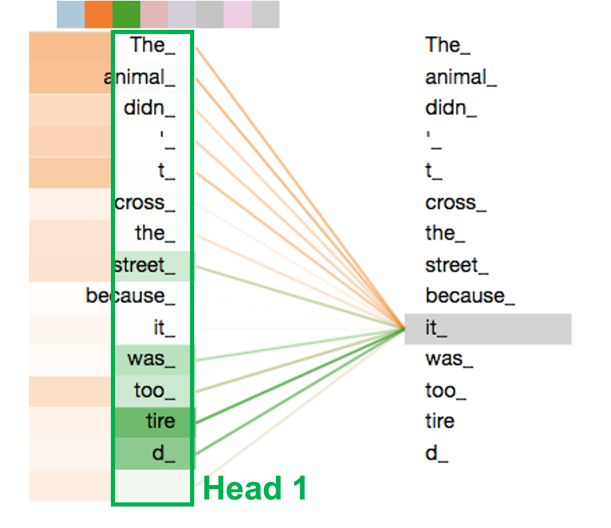

In [14]:
display_resized_image_in_notebook("self_attention_head_1.png",0.3)

> Image modified from: http://jalammar.github.io/illustrated-transformer/


Let's now focus on the orange one ("Head 2"). This attention head has a high weight on the word "animal", indicating that this attention head cares more about the word "animal" when trying to understand the meaning of the word "it".

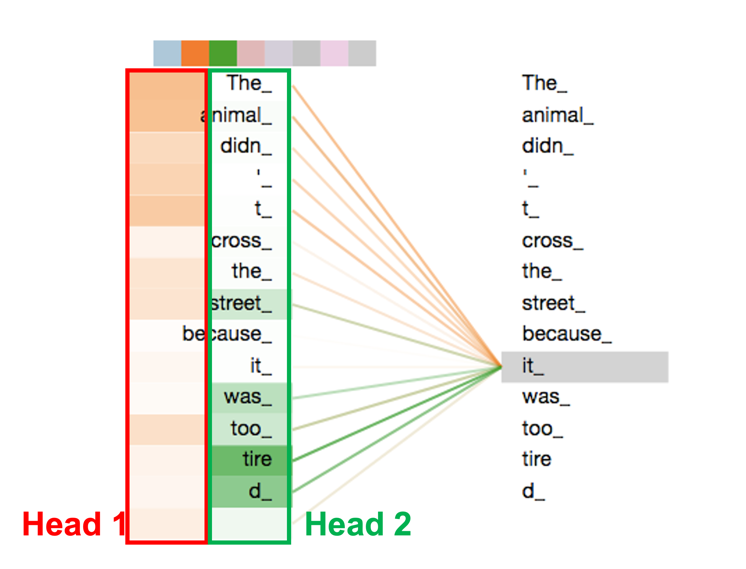

In [15]:
display_resized_image_in_notebook("self_attention_head_2.png",0.3)

> Image modified from: http://jalammar.github.io/illustrated-transformer/


In the actual BERT model, there are 12 attention heads, meaning that the model has 12 different ways of understanding the meaning of any word in a sentence. After we combine the outputs of all 12 attention heads, we then get the representation of the word "it" in the sentence after this "multi-head attention layer". This multi-head attention layer, along with other components (as shown below in the graph below), is called an "encoder".

In the BERT model, for any given input sentence, this attention mechanism is repeated 12 times (i.e., 12 encoders). Intuitively speaking, every time the vector goes through an encoder, it learns a more "abstract" relationship between words in a sentence. 

The final product after these 12 layers is the "<u>**representation**</u>" of the input sentence. In total, there are about 110 million trainable parameters in the BERT model.

To make a prediction (e.g., the stance) based on the <u>**representation**</u>, this representation vector is then fed into a linear layer to produce the final output of the model. In the case of BERT, the representation is a vector of 768 numbers (the "hidden units"). 

> Note: the number of layers, the number of attention heads, the number of encoders, are based on the `bert-base` model, which is the smaller variant of BERT. The larger variant, the `bert-large` model, has 24 encoders, 16 attention heads, and 1024 hidden units, amounting to about 340 million trainable parameters. In this tutorial, we will be using the `bert-base` model.

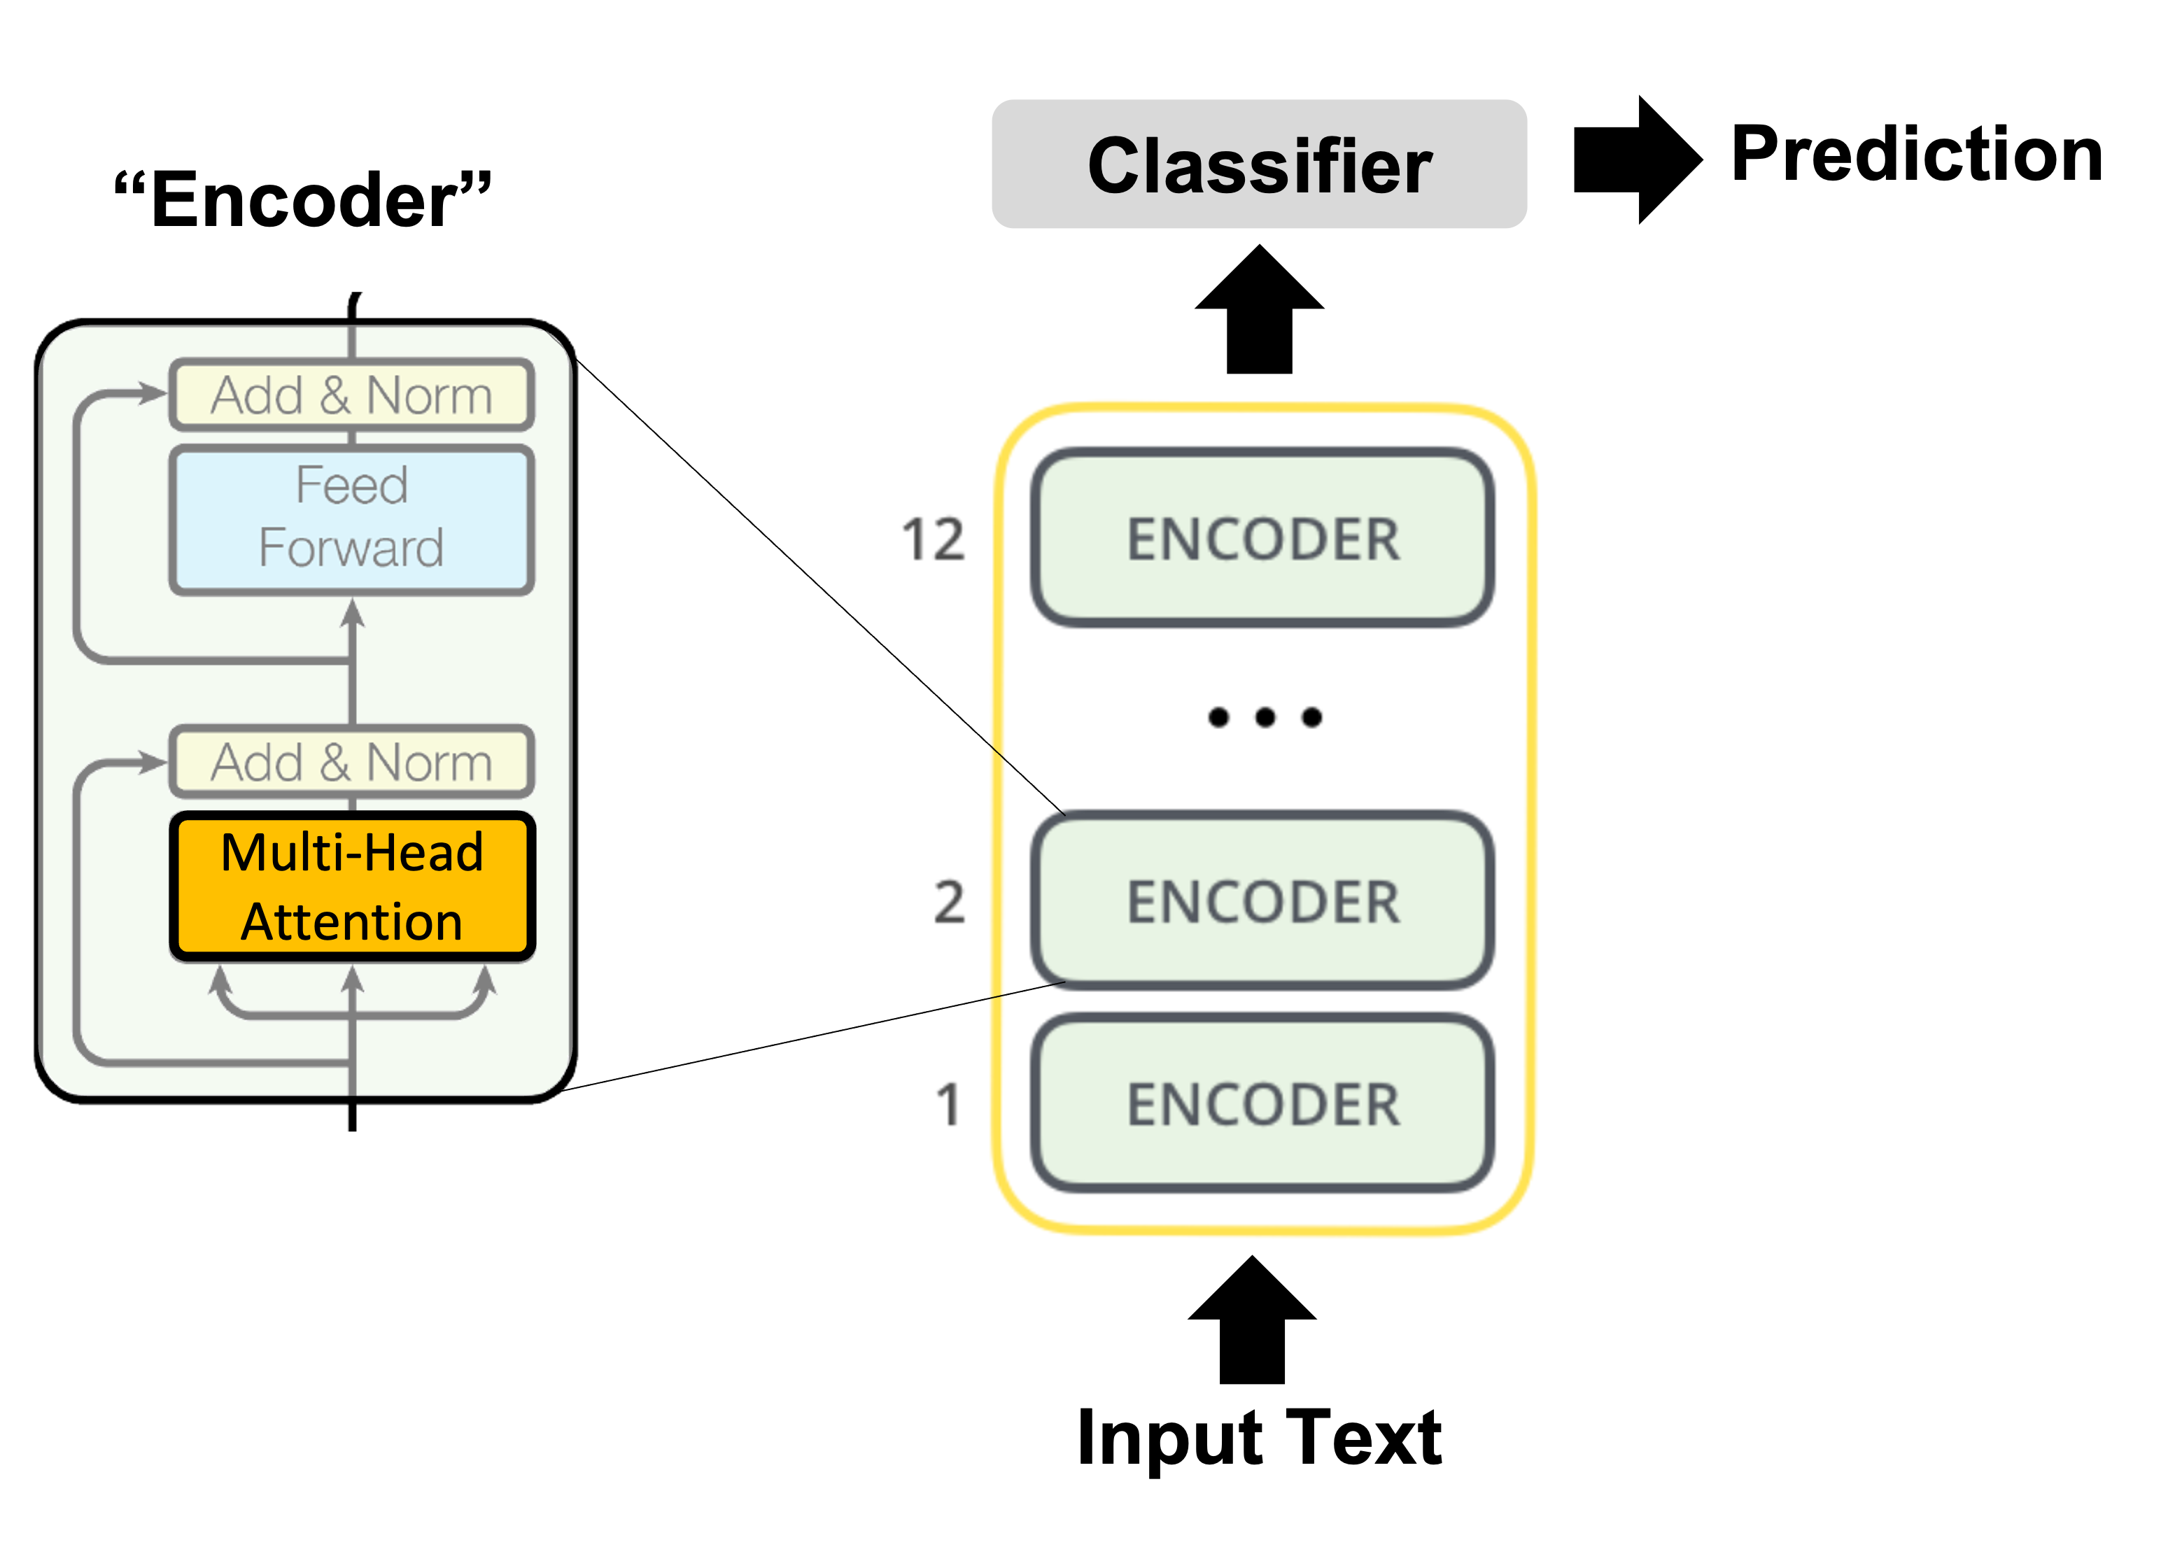

In [16]:
display_resized_image_in_notebook("bert_model_architecture.png",0.7)

> Image modified from: http://jalammar.github.io/illustrated-bert/

>  Note: The actual self-attention mechanism is more complicated. The "attention weight" is computed by three trainable matrices - the query, key, and value matrices. 

> Likewise, although the self-attention layers are arguably the most critical component, it is not the only component in a transformer. As shown in the figure aboe, there are other building blocks like layer normalization, residual connection, linear layers, positional encodings etc. If you are interested in learning more about transformers in detail, I highly recommend checking out the interactive tutorial on transformers (by Jay Alammar, the same author of the BERT tutorial linked above): http://jalammar.github.io/illustrated-transformer/. This tutorial provides a comprehensive and visually engaging explanation of the transformer architecture. Some plots in my tutorial are borrowed from this resource. Also note that there are different variants of BERT with different sizes of the transformer architecture. For example, BERT-Base has 12 self-attention layers, while BERT-Large has 24 self-attention layers. In this tutorial, we will be using BERT-Base as a running example.

****

### Pre-training and Fine-tuning: Learning from Lots of Text and Adapting to Specific Tasks

Now we know the architecture of BERT, which is a transformer model with 12 self-attention layers. But how does BERT learn to understand the meaning of words? And how can we use BERT to solve specific NLP tasks, say, stance detection? 

Note that the BERT model contains around 110 million parameters, necessitating a substantial amount of data for training. So, how can we effectively train BERT when dealing with a specific task that has a limited dataset? For instance, the Abortion dataset we used in this tutorial comprises only 933 labeled tweets.

One of the key secrets behind BERT's success is its ability to 1) learn from vast amounts of "unlabled text" and then 2) adapt that knowledge to specific tasks with labels. These two components correspond to the two stages when training a BERT model: 1) pre-training and 2) fine-tuning.


#### 1) **Pre-training phase**

During the initial pre-training phase, BERT is exposed to massive amounts of unlabeled text (the raw text itself without any annotation about sentiment, stance etc.). The standard BERT model was pretrained on the entire English Wikipedia and 11k+ online books, which in total contains about 3.3B words. 

Why do we want to pre-train BERT on these corpora, even though they are not related to the specific tasks we want to solve (i.e., the Abortion tweet dataset)? The answer is that the pre-training phase allows BERT to learn the general language understanding, for example, the meaning of words, the relationships between words, and the context of words.

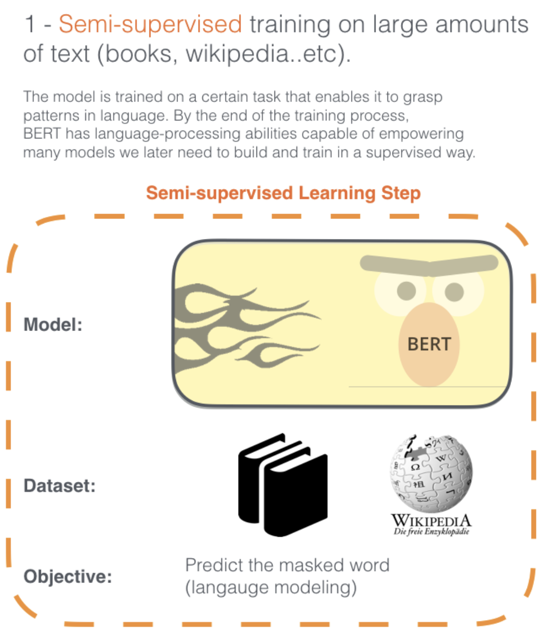

In [17]:
display_resized_image_in_notebook("bert_pretrain.png",0.5)

> Image modified from: http://jalammar.github.io/illustrated-bert/


In order to learn these general language understanding, in the pre-training phase, BERT uses two different tasks: 1) masked language modeling and 2) next sentence prediction. This phase allows BERT to learn the relationships between words even without any task-specific labels (e.g., stance labels are not needed for pre-training).

The masked language modeling task is a simple task where BERT is asked to predict some "masked out" word in a sentence. For example, given the sentence "The animal didn't cross the street because it was too tired", when pre-training BERT, the word "it" may be masked out and the model is asked to predict this missing word.

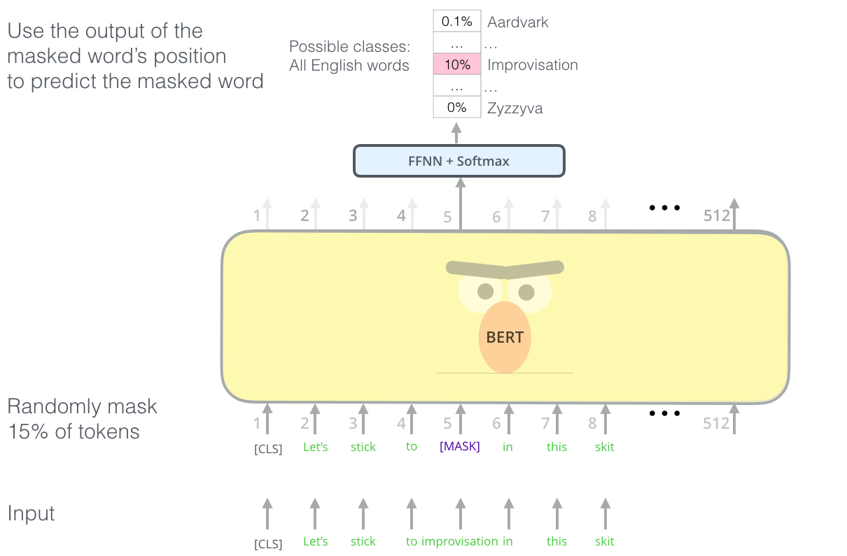

In [18]:
display_resized_image_in_notebook("bert_pretrain_mlm.png",0.7)

> Image modified from: http://jalammar.github.io/illustrated-bert/

The next sentence prediction task is a binary classification task where BERT is asked to predict whether the second sentence is a continuation of the first sentence. For example, if there is a paragraph in the training data, where "<u>_It was an sleepy dog._</u>" is the second sentence that follows the first sentence "<u>_The animal didn't cross the street because it was too tired._</u>", then we say that the second sentence is a continuation of the first sentence.

In this task, BERT is asked to decide whether a random sentence is a continuation of another sentence.

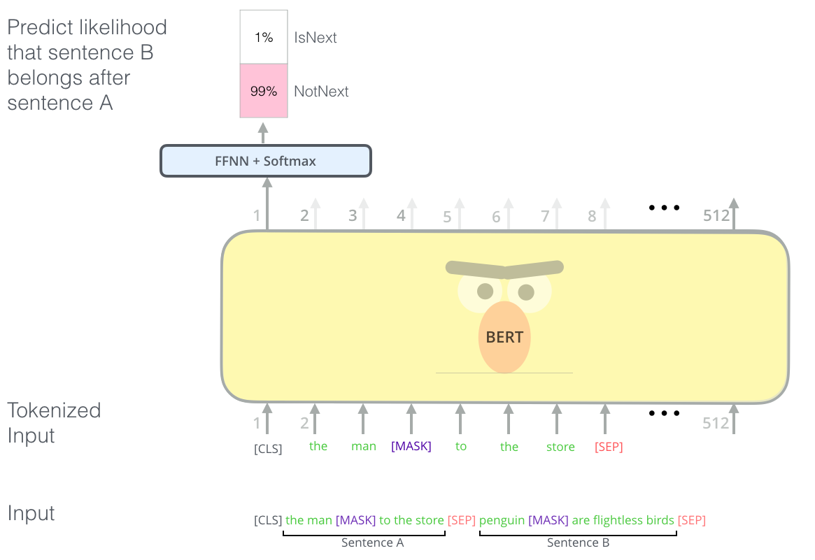

In [19]:
display_resized_image_in_notebook("bert_pretrain_next_sentence_prediction.png",0.7)

> Image modified from: http://jalammar.github.io/illustrated-bert/

> Note: One caveat about pre-training is that, the more similar the pre-training corpus is to the task-specific corpus, the better the performance of BERT. For example, if you want to use BERT to solve a stance detection task on tweets about abortion, it is better to pre-train BERT on a corpus that is similar to this dataset. For example, you can pre-train BERT on a corpus that contains tweets (rather than the original Wikipedia and online books corpus). This makes sense because the style of tweets is different from the style of Wikipedia and online books (e.g., they are shorter and more informal). More about this in the next section [Considering More Appropriate Pre-trained Models](#considering-more-appropriate-pre-trained-models).


#### 2) **Fine-tuning phase**

After pre-training, BERT can be fine-tuned for a specific task with a smaller labeled dataset (e.g., the Abortion tweet dataset). Fine-tuning involves updating the model's weights using the labeled data, allowing BERT to adapt its general language understanding to the specific task. This process is relatively fast and requires less training data compared to training a model from scratch.



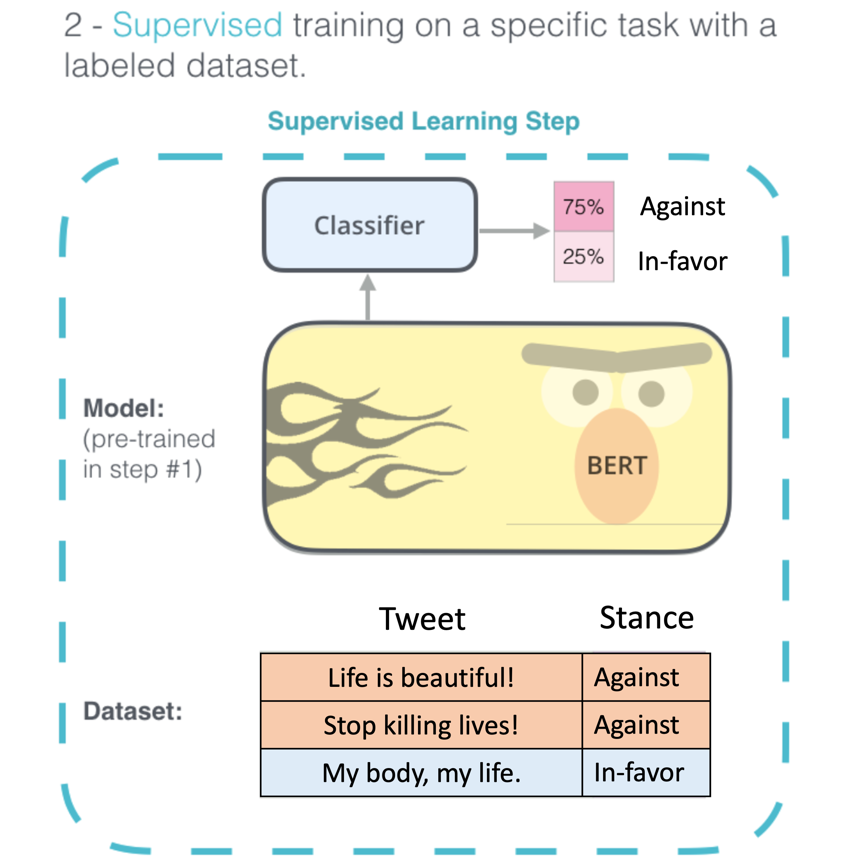

In [20]:
display_resized_image_in_notebook("bert_fine_tune_stance.png",0.35)

> Image modified from: http://jalammar.github.io/illustrated-bert/

****

### **BERT's Sub-word Tokenization**

One caveat of BERT is that it requires a special "subword-tokenization" process (i.e., WordPiece tokenization). That is, it dods not directly encode each individual word, but rather encode each word as a sequence of "sub-word tokens". For example, the word "university" can be broken down into the subwords "uni" and "versity," which are more likely to appear in the corpus than the word "university" itself. This process of breaking down words into subwords is called sub-word tokenization.

Sub-word tokenization is important for several reasons. Just to name two important ones:

#### **Consistent Representation of Similar Words**

Tokenization ensures that the text is represented in a consistent manner, making it easier for the model to learn and identify patterns in the data. By breaking the text into tokens, the model can focus on the essential units of meaning, allowing it to better understand and analyze the input.
For an example, let us consider the following two words that are commonly used in the abortion debate.: "<u>**pro-life**</u>" and "<u>**pro-choice**</u>". 

Tokenization can help standardize the text by breaking them down into smaller, overlapping tokens, i.e., `["pro", "-", "life"]` and `["pro", "-", "choice"]`. 

By representing the words as a sequence of tokens, the model can more effectively identify the commonality between them (the shared "pro-" prefix) while also distinguishing the unique parts ("life" and "choice"). This approach helps the model learn the relationships between word parts and the context (i.e., other words in the sentence) in a more generalizable way. For example, sub-word tokenization enable the model handle out-of-vocabulary words more effectively, as we will see below.

#### **Handling Out-of-Vocabulary Words**

One of the challenges in NLP is dealing with words that the model has not encountered during training, also known as out-of-vocabulary (OOV) words. By using tokenization, BERT can handle OOV words more effectively.

For example, suppose we have a sentence containing a relatively newly-coined word: "pro-birth".

Here, the word "<u>**pro-birth**</u>" is a neologism that may not be present in the model's vocabulary during pre-training, particularly if the model was trained on older data. If we used a simple word-based tokenization, the model would struggle to understand this word. However, using a subword tokenization approach, the word can be broken down into smaller parts that the model has likely seen before:

`["pro", "-", "birth"]`

This breakdown allows the model to infer the meaning of the previously unseen word based on the subword components it has encountered during training. The model can recognize the "pro" prefix and the suffix "birth". This enables BERT to better understand these out-of-vocabulary words, especially those that are relatively new or coined, making it more robust and adaptable to a wide range of text inputs.

****

# Programming Exercise: Fine-tuning a BERT Model with HuggingFace

Now, let's fine-tune a standard BERT model using the HuggingFace Transformers library.


> Hugging Face, often called the "GitHub" for NLP models, provides an extensive open-source Transformers library and a model hub, making it easy to access, share, and implement state-of-the-art NLP models like BERT (and other open-source LLMs, more on this in the second tutorial). 

First, you need to decide whether you want to train the models on your own or use the predictions I made and uploaded to my GitHub repo. If you're running this notebook for the first time, I recommend setting `DO_TRAIN_MODELS = False` (the default setting below) to save time. This will load the precomputed predictions from my GitHub repo.

However, if you want to try training the models yourself, which I encourage, you can set `DO_TRAIN_MODELS = True` and rerun the notebook. If you're running this on Google Colab, ensure you're using the GPU runtime for a more efficient and faster experience. To enable this, go to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`. Note that even with the GPU runtime, running this entire notebook on Colab will take about 10-15 minutes.

> Note: I have attempted to minimize randomness in the notebook by using a random seed. However, the results you obtain may still vary slightly from those in this notebook due to factors such as different library versions or hardware configurations. To obtain the exact same results as presented in this notebook, keep `DO_TRAIN_MODELS = False` and use the precomputed predictions I made.

In [21]:
DO_TRAIN_MODELS = False

## Read the Raw Data

In [22]:
%load_ext autoreload
%autoreload 2

from data_processor import SemEvalDataProcessor
from utils import get_parameters_for_dataset, tidy_name, display_resized_image_in_notebook

/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# set up 
SEED = 42
TOPIC_OF_INTEREST = "Abortion"
DATASET = "SEM_EVAL"
par = get_parameters_for_dataset(DATASET)

In [24]:
# read the raw data
sem_eval_data = SemEvalDataProcessor()
df_raw_train = sem_eval_data._read_raw_data(read_train=True,read_test=False,topic=TOPIC_OF_INTEREST)
df_raw_test = sem_eval_data._read_raw_data(read_train=False,read_test=True,topic=TOPIC_OF_INTEREST)

Let's look at the raw data first. The raw data is in the format below. 

Each line contains a ID of the text, a target topic (which is "Legalization of Abortion"), the raw tweet content, and a stance label (i.e., `FAVOR`, `AGAINST`, `NONE`).

In [25]:
df_raw_train[["ID","Target","Tweet","Stance"]].head()

,ID,Target,Tweet,Stance
2211,2312,Legalization of Abortion,I really don't understand how some people are ...,AGAINST
2212,2313,Legalization of Abortion,Let's agree that it's not ok to kill a 7lbs ba...,AGAINST
2213,2314,Legalization of Abortion,@glennbeck I would like to see poll: How many ...,AGAINST
2214,2315,Legalization of Abortion,"Democrats are always AGAINST ""Personhood"" or w...",AGAINST
2215,2316,Legalization of Abortion,"@CultureShifting ""If you don't draw the line w...",NONE


In [26]:
print("number of tweets in the training data: ",len(df_raw_train))

number of tweets in the training data:  603


The testing data below has the same format. Note that this set is not used for training, but for evaluating a trained model's performance on unseen data.

In [27]:
df_raw_test[["ID","Target","Tweet","Stance"]].head()

,ID,Target,Tweet,Stance
969,10970,Legalization of Abortion,Need a ProLife R.E. Agent? - Support a ProLife...,AGAINST
970,10971,Legalization of Abortion,Where is the childcare program @joanburton whi...,AGAINST
971,10972,Legalization of Abortion,I get several requests with petitions to save ...,AGAINST
972,10973,Legalization of Abortion,"we must always see others as Christ sees us,we...",AGAINST
973,10974,Legalization of Abortion,PRAYERS FOR BABIES Urgent prayer one in Lexing...,AGAINST


In [28]:
print("number of tweets in the test data: ",len(df_raw_test))

number of tweets in the test data:  280


Let's look at some examples of the raw tweets.

In [29]:
# convert to list
df_raw_train[["Tweet"]].values[[7,21]].tolist()

[['RT @createdequalorg: "We\'re all human, aren\'t we? Every human life is worth the same, and worth saving." -J.K. Rowling #... #SemST'],
 ['Follow #Patriot --> @Enuffis2Much.  Thanks for following back!!  #Truth #Liberty #Justice #ProIsrael #WakeUpAmerica #FreeAmirNow #SemST']]

We can see that the tweets are not very clean. 

For example, the first tweet contains a retweet tag (i.e., "RT @createdequalorg"). This tag entails that the tweet is a retweet of another tweet. This messsage is not part of the content of the original tweet, and thus should be removed. 


Aside from the retweet tag, the tweets also contain some other noise, such as some special characters (e.g., /\'). We will also remove these special characters.

In addition, the mentions (e.g., "@Enuffis2Much") contains the reference to other users. These mentions may confuse the model and should be removed as well.


> Note: In practice, these non-language features can be leveraged to improve the model's performance for various text sources. However, we will not be exploring that approach in this tutorial to maintain a general focus on the core techniques and to accommodate a wide range of text types.

Finally, all tweets end with a special hashtag (e.g., "#SemST"). These hashtags are added by the owners of the SemST dataset to indicate the stance of the tweet, and are not part of the original tweet content. We will also remove these special hashtags.

## Preprocess the Raw Data

We will preprocess the raw data to address the issues mentioned above.

Aside from preprocessing the raw tweets, we will also partition the training data into a training set and a validation set (with a 4:1 ratio). The validation set will be used to evaluate the model's performance during training.

In [30]:
# preprocess the raw tweets
sem_eval_data.preprocess()
df_processed = sem_eval_data._read_preprocessed_data(topic=TOPIC_OF_INTEREST).reset_index(drop=True)

In [31]:
# partition the data into train, vali, test sets
df_partitions = sem_eval_data.partition_processed_data(seed=SEED,verbose=False)

Let's look at the preprocessed data. The first thing to notice is that there is a new column called "partitions". This column indicates whether the tweet belongs to the training set, validation set, or testing set.

In [32]:
df_processed.head()

,ID,tweet,topic,label,partition
0,2312,i really don't understand how some people are ...,Abortion,AGAINST,train
1,2313,let's agree that it's not ok to kill a 7lbs ba...,Abortion,AGAINST,train
2,2314,@USERNAME i would like to see poll: how many a...,Abortion,AGAINST,train
3,2315,democrats are always against 'personhood' or w...,Abortion,AGAINST,train
4,2316,@USERNAME 'if you don't draw the line where i'...,Abortion,NONE,train


Let's look at the preprocessed tweets. 

We can see that the tweets are now much cleaner. For example, the retweet tag, special characters, and special hashtags have been removed. The mention tags are replaced by a sentinel token (i.e., "@USERNAME").

In [33]:
df_processed[["tweet"]].values[[7,21]].tolist()

[["'we're all human, aren't we? every human life is worth the same, and worth saving.' -j.k. rowling #..."],
 ['follow #patriot --> @USERNAME. thanks for following back!! #truth #liberty #justice #proisrael #wakeupamerica #freeamirnow']]

Let's look at the distribution of the stance labels across the training, validation, and testing sets.

In [43]:
# add a "count" column to count the number of tweets in each partition
df_label_dist = df_partitions[df_partitions.topic == TOPIC_OF_INTEREST].value_counts(['partition','label']).sort_index()

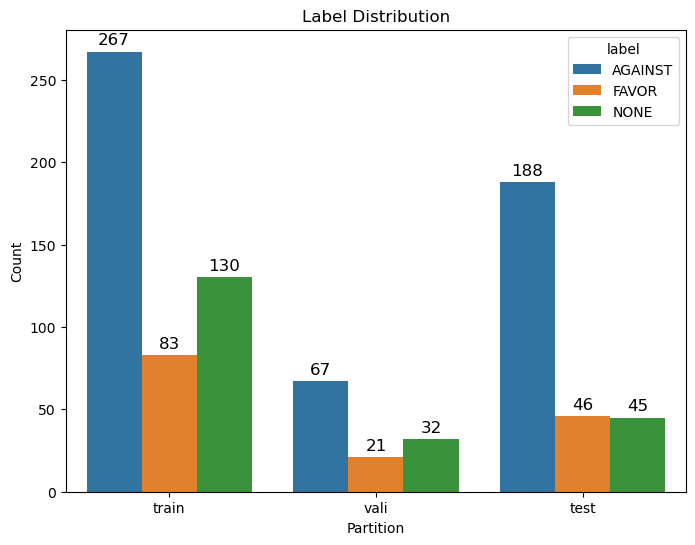

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

df_label_dist_plot = df_label_dist.reset_index()


# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_label_dist_plot, x="partition", y=0, hue="label", order=["train", "vali", "test"])

# Customize the plot
plt.xlabel("Partition")
plt.ylabel("Count")
plt.title("Label Distribution")

# Add count on top of each bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='baseline',
        fontsize=12,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )
# Show the plot
plt.show()

# Train a stadard BERT model

- Here, I use the BERT-base-uncased model, which is a standard BERT model with 12 self-attention layers and 110 million parameters.

In [27]:
import pandas as pd
from os.path import join

from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch as th


from data_processor import SemEvalDataProcessor
from utils import process_dataframe, preprocess_dataset, partition_and_resample_df, evaluate_trained_trainer_over_sets, func_compute_metrics_sem_eval, remove_saved_models_in_checkpoint, remove_checkpoint_dir, seed_all,convert_stance_code_to_text

## Set up

In [28]:
# use the standard bert model
ENCODER = "bert-base-uncased"
PATH_OUTPUT_ROOT = par.PATH_RESULT_SEM_EVAL_TUNING

Use GPU if available

In [29]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print('Using device:', device)
seed_all(SEED)


Using device: cuda


In [30]:
# specify the output path
path_run_this = join(PATH_OUTPUT_ROOT, ENCODER)
file_metrics = join(path_run_this, "metrics.csv")
file_confusion_matrix = join(path_run_this, "confusion_matrix.csv")
file_predictions = join(path_run_this, "predictions.csv")
print("path_run_this:", path_run_this)
print("file_metrics:", file_metrics)
print("file_confusion_matrix:", file_confusion_matrix)
print("file_predictions:", file_predictions)


path_run_this: /home/sean/prelim_stance_detection/results/semeval_2016/tuning/bert-base-uncased
file_metrics: /home/sean/prelim_stance_detection/results/semeval_2016/tuning/bert-base-uncased/metrics.csv
file_confusion_matrix: /home/sean/prelim_stance_detection/results/semeval_2016/tuning/bert-base-uncased/confusion_matrix.csv
file_predictions: /home/sean/prelim_stance_detection/results/semeval_2016/tuning/bert-base-uncased/predictions.csv


In [31]:
# Load the preprocessed data and the partitions
data_processor = SemEvalDataProcessor()
func_compute_metrics = func_compute_metrics_sem_eval()
file_processed = data_processor._get_file_processed_default(topic=TOPIC_OF_INTEREST)
df_partitions = data_processor.read_partitions(topic=TOPIC_OF_INTEREST)

df = process_dataframe(input_csv=file_processed,
                        dataset=DATASET)

Note that there is a label imbalance issue in the dataset. There are way more tweets with the `AGAINST` label than the other two labels. This may cause the model to be biased towards predicting the `AGAINST` label.

To address this issue, we will first upsample the training set to make the number of tweets with each label equal.

> To learn more about the data imbalance issue, I recommend taking a look at this tutorial https://towardsdatascience.com/5-techniques-to-work-with-imbalanced-data-in-machine-learning-80836d45d30c

In [32]:
# upsample the minority class
dict_df = partition_and_resample_df(df, SEED, "single_domain",
                                    factor_upsample=1,
                                    read_partition_from_df=True,
                                    df_partitions=df_partitions)

Let's check if the upsampled data is balanced now.

In [33]:
# before upsampling
dict_df["train_raw"]["label"].apply(lambda x: convert_stance_code_to_text(x, DATASET)).value_counts().sort_index()

AGAINST    267
FAVOR       83
NONE       130
Name: label, dtype: int64

In [34]:
# after upsampling
dict_df["train_upsampled"]["label"].apply(lambda x: convert_stance_code_to_text(x, DATASET)).value_counts().sort_index()

AGAINST    267
FAVOR      267
NONE       267
Name: label, dtype: int64

## Load the tokenizer and tokenize the tweets

Recall that BERT requires a special "subword-tokenization" process (i.e., WordPiece tokenization). That is, it does not directly encode each individual word, but rather encode each word as a sequence of "sub-word tokens". For example, the word "university" can be broken down into the subwords "uni" and "versity," which are more likely to appear in the corpus than the word "university" itself. This process of breaking down words into subwords is called sub-word tokenization.

In [35]:
# load the tokenizer and preprocess the data
tokenizer = AutoTokenizer.from_pretrained(ENCODER)
dict_dataset = dict()
for data_set in dict_df:
    dict_dataset[data_set] = preprocess_dataset(dict_df[data_set],
                                                tokenizer,
                                                keep_tweet_id=True,
                                                col_name_tweet_id=par.TEXT_ID)

In [36]:
# the processed data set has the following structure
# - text: the text of each tweet
# - label: the label of each stance
# - input_ids: the "token ids" of each tweet
dict_dataset["train_upsampled"]

Dataset({
    features: ['text', 'ID', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 801
})

### Let's look at one example tweet after tokenization

The sentence "<u>_i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old._</u>" is converted into the following tokens ID:

_[101, 1045, 2428, 2123, 1005, 1056, 3305, 2129, 2070, 2111, 2024, 4013, 1011, 3601, 1012, 1037, 2166, 2003, 1037, 2166, 2053, 3043, 2065, 2009, 1005, 1055, 1016, 3134, 2214, 2030, 2322, 2086, 2214, 1012,  102, 0, 0, ..., 0]_

> The "0" at the end are the padding tokens. They not used to train the model. Rather, they are used to make all the tweets within a batch have the same length. This is a common practice when training neural network models using batches.

In [37]:
print("The original text of this tweet: \n {}\n".format(dict_dataset["train_upsampled"]["text"][0]))
print("The label of this tweet: \n {}\n".format(convert_stance_code_to_text(
    dict_dataset["train_upsampled"]["label"][0].item(), DATASET)))
print("The token ids of this tweet: \n {}\n".format(dict_dataset["train_upsampled"]["input_ids"][0]))

The original text of this tweet: 
 i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

The label of this tweet: 
 AGAINST

The token ids of this tweet: 
 tensor([ 101, 1045, 2428, 2123, 1005, 1056, 3305, 2129, 2070, 2111, 2024, 4013,
        1011, 3601, 1012, 1037, 2166, 2003, 1037, 2166, 2053, 3043, 2065, 2009,
        1005, 1055, 1016, 3134, 2214, 2030, 2322, 2086, 2214, 1012,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,

The tokens ID can be converted back to the original tokens, also using the tokenizer.

Let look at the first 10 tokens of the first tweet.

Notice that the word "pro-choice" is broken down into the subwords "pro", "-", and "choice", as explained above.

In [38]:
for i in range(15):
    token_id_this = dict_dataset["train_upsampled"]["input_ids"][0][i].item()
    token_this = tokenizer.decode(token_id_this)
    print("token_id: {}; token: {}".format(
        token_id_this,
        token_this)
    )

token_id: 101; token: [CLS]
token_id: 1045; token: i
token_id: 2428; token: really
token_id: 2123; token: don
token_id: 1005; token: '
token_id: 1056; token: t
token_id: 3305; token: understand
token_id: 2129; token: how
token_id: 2070; token: some
token_id: 2111; token: people
token_id: 2024; token: are
token_id: 4013; token: pro
token_id: 1011; token: -
token_id: 3601; token: choice
token_id: 1012; token: .


> The "[CLS]" token is another special token (just like the padding token aboe) that is added to the beginning of each tweet. It is how BERT knows that the tweet is the beginning of a new sentence.

In [39]:
# "decode" the entire sequence
tokenizer.decode(dict_dataset["train_upsampled"]["input_ids"][0],skip_special_tokens=True)

"i really don't understand how some people are pro - choice. a life is a life no matter if it's 2 weeks old or 20 years old."

Next, we want to load a pre-trained BERT model, which will be used to initialize the weights of our model. We will use `bert-base-uncased` model, which is a standard BERT model with 12 self-attention layers and 110 million parameters.

In [40]:
print("The BERT model to use: {}".format(ENCODER))

The BERT model to use: bert-base-uncased


In [41]:
# load the pretrained model
model = AutoModelForSequenceClassification.from_pretrained(ENCODER,
                                                          num_labels = par.DICT_NUM_CLASS[DATASET])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Great! After loading the pre-trained BERT model, now we are ready to fine-tune the BERT model.
We are going to use the classes `Trainer` and `TrainingArguments` provided by the HuggingFace library.

Let's specify the training arguments, including the number of epochs, the batch size, and the learning rate etc.

While the model is being trained, we retain the best model at each epoch based on the macro F1 score on the validation set. The macro F1 score is the average of the F1 scores across all three stance classes.

> To learn more about macro-F1 score, I recommend taking a look at this tutorial https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20macro%2Daveraged%20F1%20score,regardless%20of%20their%20support%20values.

In [42]:
# specify the training arguments
training_args = TrainingArguments(
    # dir to save the model checkpoints
    output_dir=path_run_this,
    # how often to evaluate the model on the eval set
    # - logs the metrics on vali set
    evaluation_strategy="epoch",
    # how often to log the training process to tensorboard
    # - only log the train loss , lr, epoch etc info and not the metrics
    logging_strategy="epoch",
    # how often to save the model on the eval set
    # - load_best_model_at_end requires the save and eval strategy to match
    save_strategy="epoch",
    # limit the total amount of checkpoints. deletes the older checkpoints in output_dir.
    save_total_limit=1,
    # initial learning rate for the adamw optimizer
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    seed=SEED,
    data_seed=SEED,
    # retain the best model (evaluated by the metric on the eval set)
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    # number of updates steps to accumulate the gradients for, before performing a backward/update pass
    gradient_accumulation_steps=1,
    optim="adamw_torch",
    report_to="none"
)      

In [43]:
# Specify the trainer
trainer = Trainer(model=model, args=training_args,
                  train_dataset=dict_dataset["train_upsampled"],
                  eval_dataset=dict_dataset["vali_raw"],
                  compute_metrics=func_compute_metrics
                  )

### Fine-tune the BERT model!

In [44]:
# Train the model
if DO_TRAIN_MODELS:
  trainer.train()

/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Class 0,F1 Class 1,F1 Class 2,Accuracy,Recall Macro,Recall Class 0,Recall Class 1,Recall Class 2,Precision Macro,Precision Class 0,Precision Class 1,Precision Class 2
1,1.051200,1.034407,0.508102,0.555556,0.468750,0.500000,0.508333,0.575782,0.625000,0.714286,0.388060,0.517180,0.500000,0.348837,0.702703
2,0.807400,0.830595,0.675755,0.732394,0.576923,0.717949,0.691667,0.717884,0.812500,0.714286,0.626866,0.663513,0.666667,0.483871,0.840000
3,0.483700,0.733062,0.663528,0.688525,0.565217,0.736842,0.691667,0.668880,0.656250,0.619048,0.731343,0.662187,0.724138,0.520000,0.742424
4,0.284900,0.823993,0.608647,0.696970,0.491803,0.637168,0.616667,0.656783,0.718750,0.714286,0.537313,0.611360,0.676471,0.375000,0.782609
5,0.191300,0.793230,0.629038,0.655738,0.538462,0.692913,0.650000,0.649461,0.625000,0.666667,0.656716,0.624867,0.689655,0.451613,0.733333
6,0.137200,0.762660,0.665914,0.656250,0.604651,0.736842,0.691667,0.668880,0.656250,0.619048,0.731343,0.663194,0.656250,0.590909,0.742424


/home/sean/prelim_stance_detection/scripts/utils.py:667: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_computer[name_metric] = load_metric(name_metric)
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.

### Evaluate the model performance

In [45]:
%%capture --no-stderr
if DO_TRAIN_MODELS:
    # evaluate on each partition
    df_metrics, df_confusion_matrix, dict_predictions = \
        evaluate_trained_trainer_over_sets(trainer,
                                            DATASET,
                                            dict_dataset, "set",
                                            return_predicted_labels=True,
                                            keep_tweet_id=True,
                                            col_name_tweet_id=par.TEXT_ID)

/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

In [46]:
if DO_TRAIN_MODELS:
  # save the evaluation results
  df_metrics.to_csv(file_metrics)

  # save the confusion matrix
  df_confusion_matrix.to_csv(file_confusion_matrix)

  # save the predictions
  # concatenate the predictions
  # - "train_raw", "val_raw", "test_raw"
  df_predictions = pd.concat([dict_predictions[key] for key in ["train_raw", "vali_raw", "test_raw"]], axis=0)
  # save only the tweet_id and the predicted label
  df_predictions = df_predictions[["ID", "predicted_label"]]
  # convert the predicted label to the stance code
  df_predictions["predicted_label"] = df_predictions["predicted_label"].apply(lambda x: convert_stance_code_to_text(x, DATASET))
  df_predictions.to_csv(file_predictions, index=False)

  # remove the saved model
  remove_saved_models_in_checkpoint(path_run_this)
  # remove the checkpoints
  remove_checkpoint_dir(path_run_this)

****

# Considering More Appropriate Pre-trained Domain-specific Models

While the `bert-base-uncased` model serves as a good starting point, there are other pre-trained models specifically designed for social media text analysis that use more relevant pre-training data. Two such models are BERTweet and polibertweet-mlm.

As mentioned earlier, when aiming to use BERT for a stance detection task on tweets about abortion, it is more effective to pre-train BERT on a corpus that is more similar to the Abortion tweet dataset. Given that tweets are generally shorter and more informal than Wikipedia and online books, it makes sense to pre-train BERT on a corpus that primarily consists of tweets (rather than the original Wikipedia and online books corpus). This is precisely the approach taken by domain-specific models like `BERTweet` and `polibertweet-mlm`, which focus on capturing the nuances and characteristics of social media text, making them better suited for stance detection tasks in this context.

> Note for advanced readers: It is important to mention that both BERTweet and polibertweet-mlm are based on the roberta-base architecture, a variant of BERT that has been optimized for improved performance. As a result, these domain-specific models not only benefit from more appropriate pre-training data but also from the enhancements offered by the roberta-base architecture. To understand the differences between BERT and roberta-base, I recommend taking a look at [this tutorial](https://appliedsingularity.com/2022/03/29/nlp-tutorials-part-14-roberta/)

## BERTweet

`BERTweet` is a pre-trained model specifically designed for processing and understanding Twitter data. It is trained on a large corpus of 850 million English tweets. As Twitter text contains unique language patterns, slang, and abbreviations, BERTweet is expected to perform better on stance detection tasks involving tweets compared to the general-purpose BERT model.

## Polibertweet-mlm


`Polibertweet-mlm` is a pre-trained model specifically designed for Twitter data, with a focus on political discourse. The dataset used for pretraining contains over 83 million English tweets related to the 2020 US Presidential Election. 

As the Abortion stance dataset may also involve political topics, polibertweet-mlm can also to be a suitable model for this stance detection task.

### Helper Function

Before we proceed with fine-tuning the models, we first create a wrapper function for each type of pretrained model. Using a wrapper function for the training pipeline streamlines the process of experimenting with different models, ensuring consistency, reproducibility, and maintainability.

In [47]:
def train(encoder):
    # specify the output paths
    encoder_name_tidy = tidy_name(encoder)
    path_run_this = join(PATH_OUTPUT_ROOT, encoder_name_tidy)
    file_metrics = join(path_run_this, "metrics.csv")
    file_confusion_matrix = join(path_run_this, "confusion_matrix.csv")
    file_predictions = join(path_run_this, "predictions.csv")

    # Load the preprocessed data and the partitions
    df = process_dataframe(input_csv=file_processed, dataset=DATASET)
    # upsample the minority class
    dict_df = partition_and_resample_df(df, SEED, "single_domain",
                                        factor_upsample=1,
                                        read_partition_from_df=True,
                                        df_partitions=df_partitions)
    # load the tokenizer and preprocess the data
    tokenizer = AutoTokenizer.from_pretrained(encoder)
    dict_dataset = dict()
    for data_set in dict_df:
        dict_dataset[data_set] = preprocess_dataset(dict_df[data_set],
                                                    tokenizer,
                                                    keep_tweet_id=True,
                                                    col_name_tweet_id=par.TEXT_ID)
    # specify the training arguments
    training_args = TrainingArguments(
        # dir to save the model checkpoints
        output_dir=path_run_this,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=6,
        weight_decay=0.01,
        seed=SEED,
        data_seed=SEED,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        gradient_accumulation_steps=1,
        optim="adamw_torch",
        report_to="none"
    )

    # load the pretrained model
    model = AutoModelForSequenceClassification.from_pretrained(encoder,
                                                               num_labels=par.DICT_NUM_CLASS[DATASET])

    # specify the trainer
    trainer = Trainer(model=model, args=training_args,
                      train_dataset=dict_dataset["train_upsampled"],
                      eval_dataset=dict_dataset["vali_raw"],
                      compute_metrics=func_compute_metrics
                      )

    # train the model
    trainer.train()

    # evaluate on each partition
    df_metrics, df_confusion_matrix, dict_predictions = \
        evaluate_trained_trainer_over_sets(trainer,
                                           DATASET,
                                           dict_dataset, "set",
                                           return_predicted_labels=True,
                                           keep_tweet_id=True,
                                           col_name_tweet_id=par.TEXT_ID)
    # save the evaluation results
    df_metrics.to_csv(file_metrics)

    # save the confusion matrix
    df_confusion_matrix.to_csv(file_confusion_matrix)

    # save the predictions
    # concatenate the predictions
    # - "train_raw", "val_raw", "test_raw"
    df_predictions = pd.concat([dict_predictions[key] for key in ["train_raw", "vali_raw", "test_raw"]], axis=0)
    # save only the tweet_id and the predicted label
    df_predictions = df_predictions[["ID", "predicted_label"]]
    # convert the predicted label to the stance code
    df_predictions["predicted_label"] = df_predictions["predicted_label"].apply(lambda x: convert_stance_code_to_text(x, DATASET))
    df_predictions.to_csv(file_predictions, index=False)    

    # remove the saved model
    remove_saved_models_in_checkpoint(path_run_this)
    # remove the checkpoints
    remove_checkpoint_dir(path_run_this)

In [48]:
if DO_TRAIN_MODELS:
  # BERTweet, having the same architecture as BERT-base (Devlin et al., 2019), is trained using the RoBERTa pre-training procedure
  # - https://huggingface.co/docs/transformers/model_doc/bertweet
  train("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSe

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Class 0,F1 Class 1,F1 Class 2,Accuracy,Recall Macro,Recall Class 0,Recall Class 1,Recall Class 2,Precision Macro,Precision Class 0,Precision Class 1,Precision Class 2
1,1.060900,1.019232,0.414795,0.210526,0.481013,0.552846,0.475000,0.512408,0.125000,0.904762,0.507463,0.533799,0.666667,0.327586,0.607143
2,0.828200,0.879058,0.538185,0.727273,0.506329,0.380952,0.533333,0.688729,0.875000,0.952381,0.238806,0.636075,0.622222,0.344828,0.941176
3,0.586800,0.789140,0.623922,0.705882,0.537313,0.628571,0.625000,0.699893,0.750000,0.857143,0.492537,0.642131,0.666667,0.391304,0.868421
4,0.410600,0.894458,0.569846,0.688525,0.481013,0.540000,0.558333,0.654666,0.656250,0.904762,0.402985,0.623302,0.724138,0.327586,0.818182
5,0.315500,0.783099,0.682898,0.688525,0.610169,0.750000,0.700000,0.728345,0.656250,0.857143,0.671642,0.682293,0.724138,0.473684,0.849057
6,0.263200,0.796304,0.682898,0.688525,0.610169,0.750000,0.700000,0.728345,0.656250,0.857143,0.671642,0.682293,0.724138,0.473684,0.849057


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [49]:
if DO_TRAIN_MODELS:
  # polibertweet-mlm
  # - https://huggingface.co/kornosk/polibertweet-political-twitter-roberta-mlm
  train("kornosk/polibertweet-mlm")

Some weights of the model checkpoint at kornosk/polibertweet-mlm were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at kornosk/polibertweet-mlm and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.wei

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Class 0,F1 Class 1,F1 Class 2,Accuracy,Recall Macro,Recall Class 0,Recall Class 1,Recall Class 2,Precision Macro,Precision Class 0,Precision Class 1,Precision Class 2
1,1.048300,0.973446,0.515185,0.409091,0.513514,0.622951,0.550000,0.584392,0.281250,0.904762,0.567164,0.599800,0.750000,0.358491,0.690909
2,0.793900,0.844410,0.563553,0.735294,0.493827,0.461538,0.550000,0.682355,0.781250,0.952381,0.313433,0.634259,0.694444,0.333333,0.875000
3,0.541900,0.726968,0.674142,0.742857,0.612903,0.666667,0.675000,0.751525,0.812500,0.904762,0.537313,0.675225,0.684211,0.463415,0.878049
4,0.366100,0.745772,0.678868,0.727273,0.612903,0.696429,0.683333,0.745617,0.750000,0.904762,0.582090,0.678655,0.705882,0.463415,0.866667
5,0.268200,0.786326,0.655311,0.698413,0.566667,0.700855,0.666667,0.702988,0.687500,0.809524,0.611940,0.655192,0.709677,0.435897,0.820000
6,0.227200,0.760867,0.695033,0.738462,0.607143,0.739496,0.708333,0.738747,0.750000,0.809524,0.656716,0.686380,0.727273,0.485714,0.846154


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


# Compare the performance of the different models

In [50]:
from result_summarizer import ResultSummarizer

In [51]:
LIST_MODEL_NAME = ["bert-base-uncased","vinai_bertweet_base","kornosk_polibertweet_mlm"]
# summarize the results
# - bert-base-uncased
result_summarizer = ResultSummarizer(dataset=DATASET,
                                     list_version_output=LIST_MODEL_NAME,
                                     eval_mode="single_domain",
                                     model_type="single_domain_baseline",
                                     task=None,
                                     file_name_metrics="metrics.csv",
                                     file_name_confusion_mat="confusion_matrix.csv",
                                     path_input_root=PATH_OUTPUT_ROOT,
                                     path_output=join(PATH_OUTPUT_ROOT, "summary"))
# write the summary to a csv file
df_hightlight_metrics = result_summarizer.write_hightlight_metrics_to_summary_csv(
                        list_metrics_highlight=['f1_macro', 'f1_NONE', 'f1_FAVOR', 'f1_AGAINST'],
                        list_sets_highlight=['train_raw', 'vali_raw', 'test_raw'],
                        col_name_set="set")
# reorder the rows
df_hightlight_metrics['version'] = pd.Categorical(df_hightlight_metrics['version'], categories=LIST_MODEL_NAME, ordered=True)
df_hightlight_metrics = df_hightlight_metrics.sort_values('version').reset_index(drop=True)

# visualize the results and save the figures
plot_con_mat = result_summarizer.visualize_confusion_metrices_over_domains_comb(
    ["train_raw", "vali_raw", "test_raw"],
    preserve_order_list_sets=True)


<Figure size 1500x750 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

In [52]:
# print the summary table
df_hightlight_metrics[["version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]][df_hightlight_metrics.set.isin(["test_raw"])]

,version,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
2,bert-base-uncased,test_raw,0.4748,0.4196,0.4275,0.5775
5,vinai_bertweet_base,test_raw,0.5797,0.5323,0.5401,0.6667
8,kornosk_polibertweet_mlm,test_raw,0.5616,0.5440,0.4762,0.6645


In this tutorial, we compared the performance of three different BERT models for stance detection: `bert-base-uncased`, `vinai_bertweet_base`, and `kornosk_polibertweet_mlm`. The latter two models are domain-specific, designed specifically for tweets. The results show that both domain-specific models outperform the general `bert-base-uncased` model in terms of macro-F1 scores. The `vinai_bertweet_base` model achieves the best performance with an macro-F1 score of 0.5797, followed by `kornosk_polibertweet_mlm` with a score of 0.5616, and finally, the `bert-base-uncased` model with a score of 0.4748. This demonstrates the advantage of using domain-specific models when dealing with tasks that involve specific types of data, such as social media text.

## Analyzing the Confusion Matrix for Deeper Insights

Given the performance differences observed among the three models, it is valuable to investigate their "confusion matrices" for each model Examining these matrices can also help identify potential biases, challenges, and opportunities for improvement. 

> Note: Examining the confusion matrix is essential because it provides a detailed overview of the model's performance across different classes. It reveals not only the correct predictions (true positives) but also the instances where the model made errors (false positives and false negatives). By analyzing the confusion matrix, we can identify patterns in misclassifications and gain insights into the strengths and weaknesses of the model. Here is a great tutorial on how to interpret the confusion matrix and its relationships with macro-F1 scores: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

Below are the confusion matrices for the standard `bert-base-uncased` model.

The second row are the matrices for the training set, the second row are for the validation set, and the third row are for the test set.

Each row of matrices consists of three types:

1. The leftmost matrices are the raw confusion matrices.
2. The middle matrices show the confusion matrices normalized by row (i.e., the sum of each row equals 100). In these matrices, the diagonal values correspond to the recall value of each class.
3. The rightmost matrices illustrate the confusion matrices normalized by column (i.e., the sum of each column equals 100). In these matrices, the diagonal values are the precision value for each class.

In each matrix, the rows represent the true labels, and the columns represent the predicted labels. The diagonal elements denote correct predictions, while the off-diagonal elements indicate incorrect predictions.

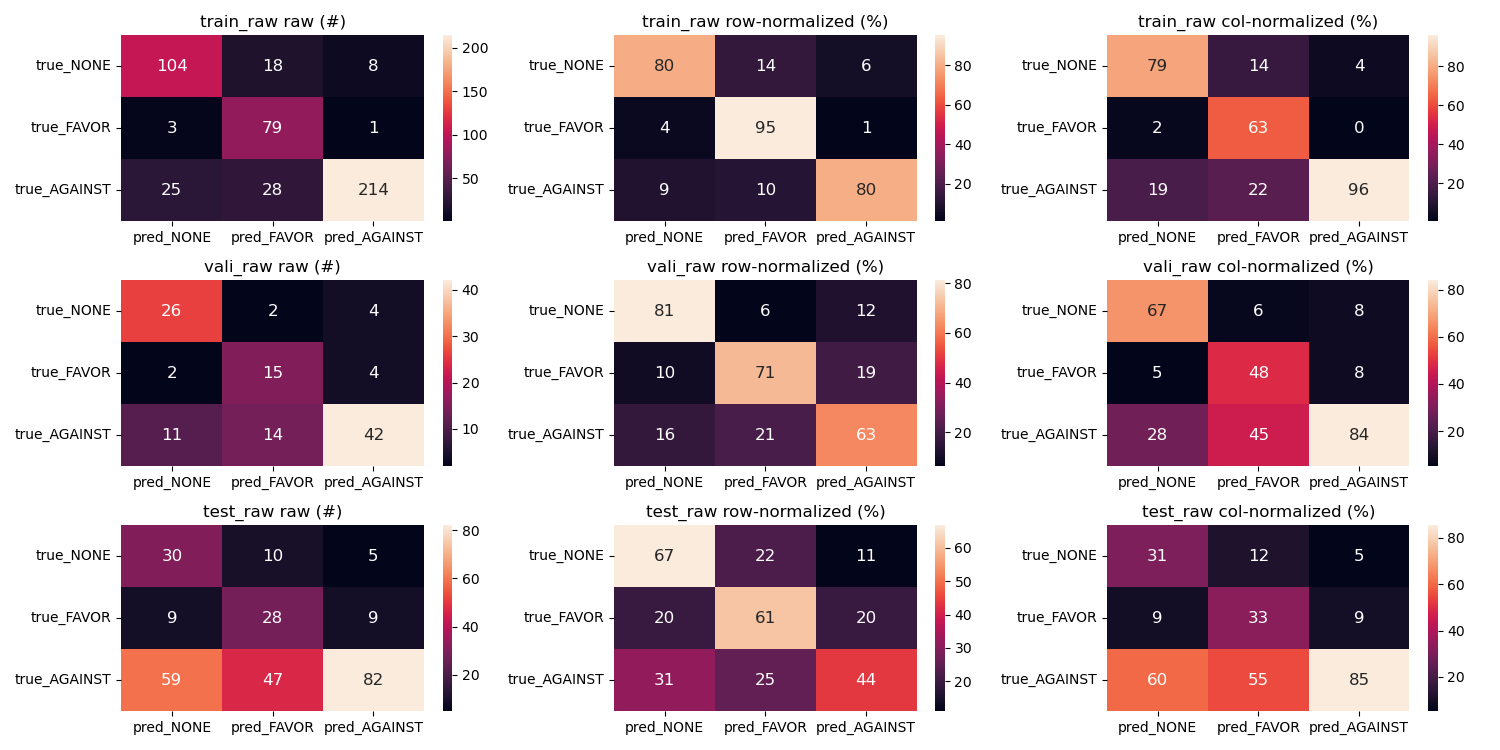

In [55]:
display_resized_image_in_notebook(join(PATH_OUTPUT_ROOT,"summary","bert-base-uncased_comb_confusion_mat.png"))

As shown in the test set confusion matrices, the model demonstrates proficiency in distinguishing between the `FAVOR` and `NONE` stances. However, it faces challenges in accurately predicting the `AGAINST` stance, frequently misclassifying them as `NONE`.

Now, let's examine the confusion matrix for the domain-specific `vinai_bertweet_base` model, which has the highest macro-F1 score.

The confusion matrices below reveal that the model is slight better at classifying all three stance classes compared to the standard `bert-base-uncased` model. 

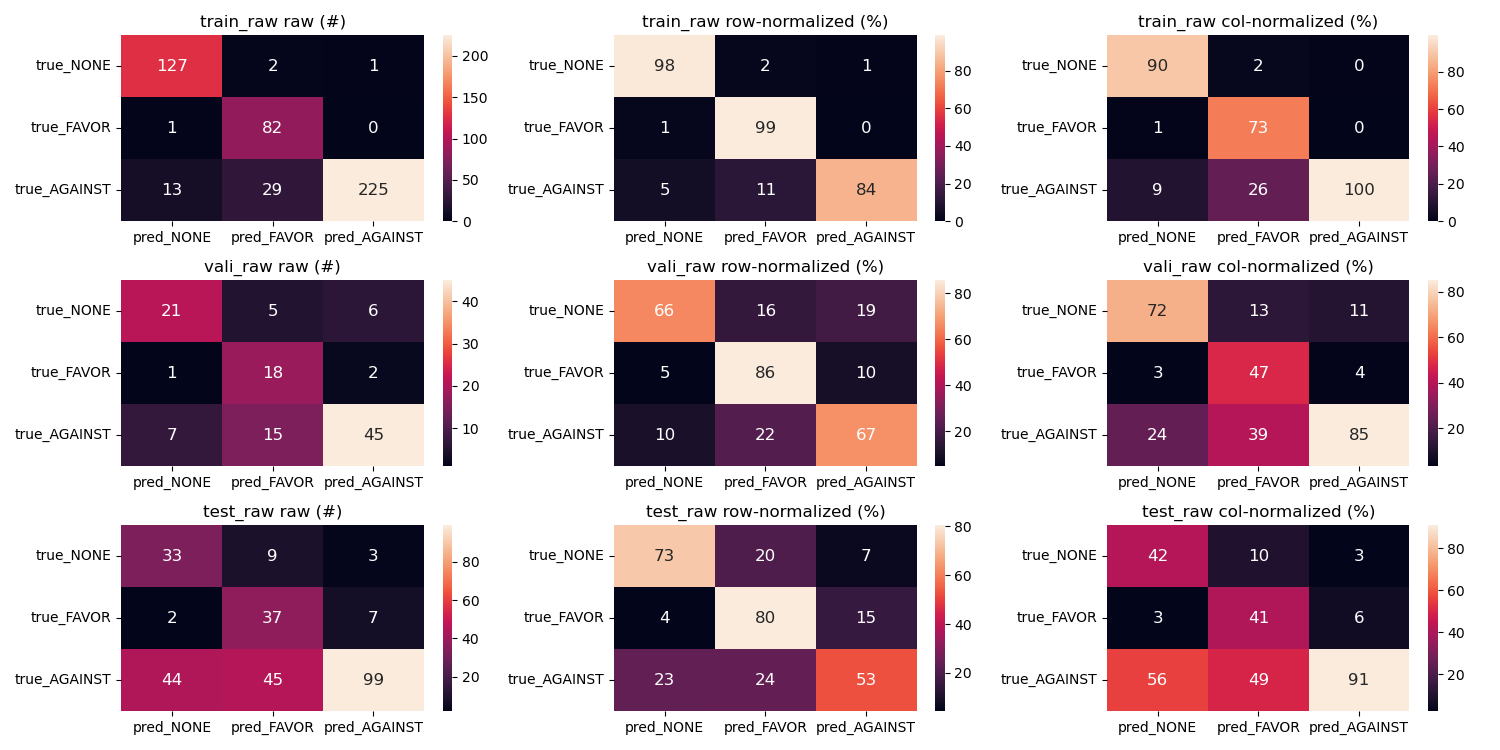

In [57]:
display_resized_image_in_notebook(join(PATH_OUTPUT_ROOT,"summary","vinai_bertweet_base_comb_confusion_mat.png"))

****

# Conclusion

In this first part of the tutorial series, we have explored stance detection, its importance, and one of the two distinct paradigms for approaching the task: tuning BERT. We discussed the concept of BERT, its architecture, and the fundamentals of transfer learning with pre-trained models. Additionally, we covered the process of tokenization in BERT, which is crucial for preparing input data.

We then walked through the process of fine-tuning a BERT model using the HuggingFace Transformers library. This involved installing the library, loading a pre-trained BERT model, preparing and processing the labeled dataset, fine-tuning the model for stance detection, and finally evaluating the model and analyzing the results.

Throughout the tutorial, we emphasized the benefits of using domain-specific models for tasks involving specific types of data, such as social media text. In the upcoming [second part](https://colab.research.google.com/drive/1IFr6Iz1YH9XBWUKcWZyTU-1QtxgYqrmX?usp=sharing) of the tutorial series, we will cover the second paradigm, prompting LLMs, and demonstrate its effectiveness in stance detection.

****